# Predicting Coding Language in 'Games' Readmes
**Author: Arsene Boundaone, Cayt Schlichting, Paige Rackley**<br>
*Audience: Target audience for our project is the Codeup Data Science cohort and instructors.*

**Project Goal:**  The goal of this project is to use natural language processing and classification models to identify terms for predicting a readme's primary language on Github.


**Jump to Section:** &ensp;   [Acquisition and Prep](#acq-prep) - [Exploration](#explore) - [Modeling](#modeling) - [Conclusion](#ConclusionC88)

In [1]:
# Ignoring warning messages from python
import warnings
warnings.filterwarnings('ignore')

#Basics
import numpy as np
import pandas as pd
from IPython.display import Markdown, display

#Viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette='colorblind') #set theme for all viz

#modeling and stats

#Modules
import prepare as prep
import utils

# Modeling imports
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

***
## Data Acquisition and Preparation  <a class="anchor" id="acq-prep">
***

**Source:** Web scrapping of Github search results. The first 500 repos with the keyword of 'games' on the search date of July 22, 2022 were used.

**Filtering:**
> - Any repos without readmes or without a language were dropped.
> - Any repos whose language occured less than 10 times in the dataset were dropped.

**Cleaning on Readme Contents:**
> - Normalized to unicode and ascii
> - Removed markdown character strings such as '\n', '\r', '(http..', etc
> - Removed any characteres that were not: a-z, 0-9, or whitespace
> - Stripped whitespace


##### Acquire, Prep and Split data

In [2]:
#Acquisition and Prep
df = prep.prep_data()

In [3]:
#split
train, validate, test = prep.split_data(df)

In [4]:
# checking for column names and make sure dtypes are objects
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197 entries, 115 to 153
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   repo      197 non-null    object
 1   language  197 non-null    object
 2   content   197 non-null    object
dtypes: object(3)
memory usage: 6.2+ KB


***
## Exploration  <a class="anchor" id="explore" />
***
*More exploration can be found in the supporting notebooks*

**Initial Questions:**
> - What are the top 5 programming languages when searching for 'Game' repos in github?
> - What are the most common words for some of these languages?
> - How do the most common words for a language compare to the highest TF-IDF scores for that language?
> - What are common bigrams for some of these languages? Are they significant to the kind of programming language?
> - Do library names help indicate a readme language?


##### Target variable distribution

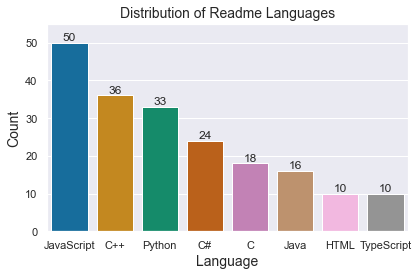

In [5]:
# function to bring in top languages for 'games' repos
utils.plot_target_distro(train)

In [6]:
#create aggregated TF-IDF dataframe (only 1 document per language)
tr_tfidf = utils.create_aggregated_tfidf(train)

### Top Words and Bigrams for Python

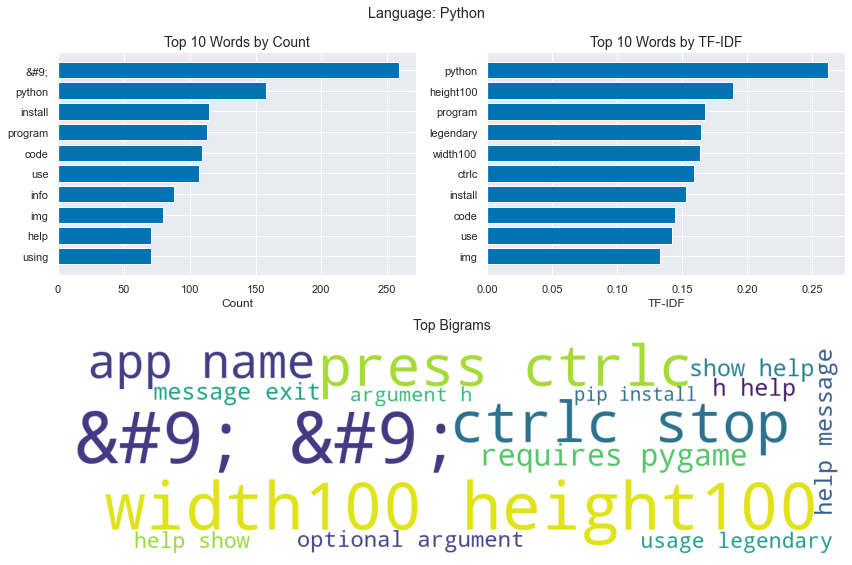

In [7]:
#Python plots
utils.generate_plots_and_cloud('Python',train,tr_tfidf)

<div class="alert alert-success"><b>Notes:</b>
<ul>
    <li>We notice that the word 'tab' is the most frequent word for Python, however, it is not in the top 10 based on the TF-IDF score. What that means is that 'tab' is also highly used in other language repos.</li>
    <li>We notice that the word Python is the second highest used word in Python repos, but it is the top word for the TF-IDF score. What this means is that python is rarely used in other language repos.</li>
    <li>We see from the bigram, 'pip install', which is a common action we use in Python while using Command Line.</li>
</ul>
</div>

### Top Words and Bigrams for C#

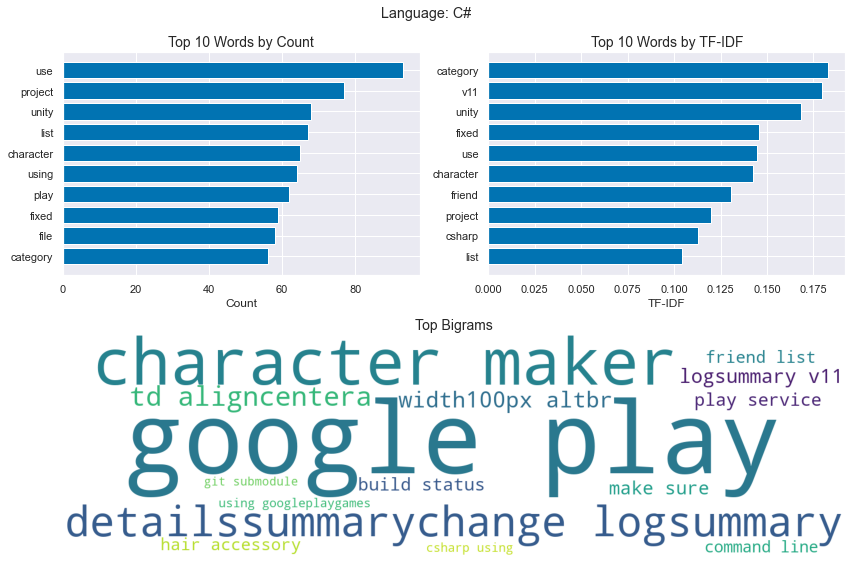

In [8]:
# C# plots
utils.generate_plots_and_cloud('C#',train,tr_tfidf)

<div class="alert alert-success"><b>Notes:</b>
<ul>
    <li>In C# we see a similar trend to python. The word csharp makes it into our top words in our TF-IDF score but isn't even present in our top words by count for C# repos. </li>
    <li>Conversely, a common word like 'use' is showing to be the top word for C# repos, but drops significantly in the TF-IDF score. </li>
    <li>Without further understanding of the C# language, it's hard to say if any of the bigrams are notable. The most common ones, 'google play' and 'character maker' seem generic, but may be product that C# is one of the least common languages.</li>
</ul>
</div>

### Top Words and Bigrams for JavaScript

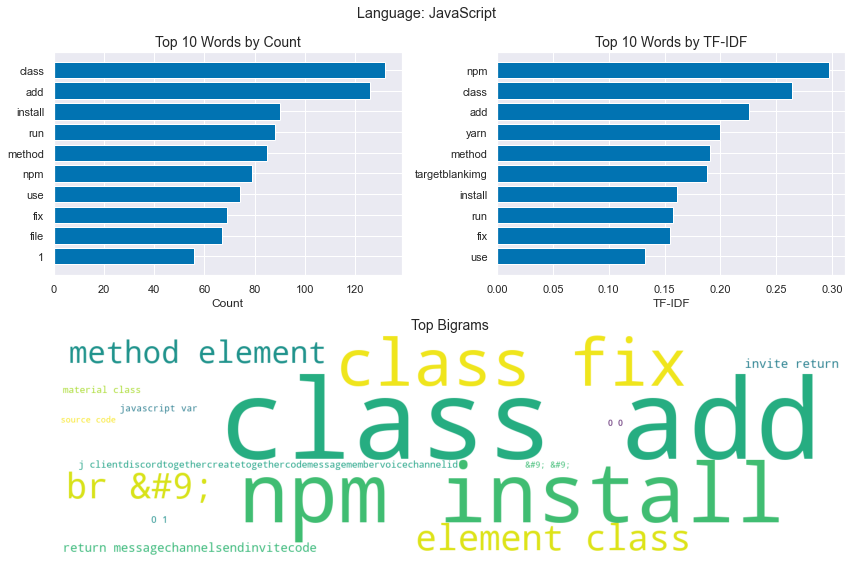

In [9]:
#JavaScript Plots
utils.generate_plots_and_cloud('JavaScript',train,tr_tfidf)

<div class="alert alert-success"><b>Notes:</b>
<ul>
    <li>In this we can see that "npm" is the top word by TF-IDF, while it is ranked 6th by raw count.  NPM is a package management library for Javascript.  This is one example showing that a libary name may help identify the underlying language.</li>
    <li>It's important to note that 'class' is appearing at the top of both the count and TF-IDF scores. What this shows is how common this word is and how often it is used.</li>
    <li>Bigram shows multiple that include 'class', showing how often it is used again.</li>
</ul>
</div>

### Exploration Summary:

In the 3 languages we looked at, we saw that Python and C# had similar trends, where a top word by count for the specific language repos either dropped or were entirey not present on the TF-IDF scores. What that tells us is that there are specific words that are very common for the specific languages and can help us predict the language with those words.


***
## Modeling <a class="anchor" id="modeling" />
***
*More modeling can be found in the supporting notebooks*
    
**Model Evaluation:** The models will primarily be evaluated using an accuracy score.  We want the highest overall accuracy possible.  The secondary criteria will be precision - with JavaSript being the positive case.  Since JavaScript is the most popular language, we want to minimize the False Positives.

In [10]:
# Vectorizing and 'learning' on train dataset

tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(train.content)
y_train = train.language

In [11]:
# Applying the vectorization without giving out the content of validate
X_validate = tfidf.transform(validate.content)
y_validate = validate.language

In [12]:
# Applying the vectorization without giving out the content of validate
X_test = tfidf.transform(test.content)
y_test = test.language

### Creating a baseline

In [13]:
# Creating a dataframe of the target variable for creating a baseline
y_train_df = pd.DataFrame(dict(actual=y_train))

# Since JavaScript has the highest occurence I'll use it as positive case
y_train_df['baseline'] = y_train_df['actual'] == 'JavaScript'

# Calculating the baseline model
print(f'The baseline model has an average capture rate for Javascript of: {y_train_df.baseline.mean():.2%}')

The baseline model has an average capture rate for Javascript of: 25.38%


### Logistic Regression Model

In [14]:
# Logistic Regression Default setup on validate dataset
lm = LogisticRegression().fit(X_train, y_train)
y_validate_pred = lm.predict(X_validate)

# Printing the accuracy value, the confusion matrix, and the classification report
print('Accuracy: {:.2%}'.format(accuracy_score(y_validate, y_validate_pred)))
print('------------------')
print('Confusion Matrix')
print(pd.crosstab(y_validate_pred, y_validate))
print('------------------')
print('Classification Report')
print('\n')
print(classification_report(y_validate, y_validate_pred))

Accuracy: 45.88%
------------------
Confusion Matrix
language    C  C#  C++  HTML  Java  JavaScript  Python  TypeScript
row_0                                                             
C           1   0    0     0     0           0       0           0
C#          0   2    0     0     0           0       0           0
C++         1   0    6     0     3           0       1           0
HTML        0   0    0     2     0           0       0           0
JavaScript  5   9    9     2     4          22       7           4
Python      0   0    1     0     0           0       6           0
------------------
Classification Report


              precision    recall  f1-score   support

           C       1.00      0.14      0.25         7
          C#       1.00      0.18      0.31        11
         C++       0.55      0.38      0.44        16
        HTML       1.00      0.50      0.67         4
        Java       0.00      0.00      0.00         7
  JavaScript       0.35      1.00      0.52

### Random Forest Classifier Model

In [15]:
# Random Forest Default setup on validate dataset
for i in range(3, 13):
    multi_depth = RandomForestClassifier(max_depth=i, random_state=175)

    all_rf = multi_depth.fit(X_train, y_train)

    y_pred_validate_rfc = all_rf.predict(X_validate)

    report = classification_report(y_validate, y_pred_validate_rfc, output_dict=True)
    print(f'RandomForest depth {i}\n')
    print(pd.DataFrame(report))
    print('\n=======================\n')

RandomForest depth 3

             C    C#        C++      HTML  Java  JavaScript     Python  \
precision  0.0   0.0   0.600000  1.000000   0.0    0.285714   1.000000   
recall     0.0   0.0   0.187500  0.500000   0.0    1.000000   0.071429   
f1-score   0.0   0.0   0.285714  0.666667   0.0    0.444444   0.133333   
support    7.0  11.0  16.000000  4.000000   7.0   22.000000  14.000000   

           TypeScript  accuracy  macro avg  weighted avg  
precision         0.0  0.329412   0.360714      0.398655  
recall            0.0  0.329412   0.219866      0.329412  
f1-score          0.0  0.329412   0.191270      0.222148  
support           4.0  0.329412  85.000000     85.000000  


RandomForest depth 4

             C         C#        C++      HTML  Java  JavaScript     Python  \
precision  0.0   0.500000   0.625000  1.000000   0.0    0.309859   0.500000   
recall     0.0   0.090909   0.312500  0.500000   0.0    1.000000   0.071429   
f1-score   0.0   0.153846   0.416667  0.666667   0.

### K-Nearest Neighbor Classifier

In [16]:
# KNN Default values on validate dataset
for i in range(3, 13):
    knn_depth = KNeighborsClassifier(n_neighbors=i)

    all_knn = knn_depth.fit(X_train, y_train)

    y_val_pred_knn = all_knn.predict(X_validate)

    report = classification_report(y_validate, y_val_pred_knn, output_dict=True)
    print(f'KNN depth {i}\n')
    print(pd.DataFrame(report))
    print('\n=======================\n')

KNN depth 3

                  C    C#      C++      HTML  Java  JavaScript  Python  \
precision  0.062500   0.0   0.5625  1.000000   0.0    0.666667     0.0   
recall     0.571429   0.0   0.5625  0.500000   0.0    0.090909     0.0   
f1-score   0.112676   0.0   0.5625  0.666667   0.0    0.160000     0.0   
support    7.000000  11.0  16.0000  4.000000   7.0   22.000000    14.0   

           TypeScript  accuracy  macro avg  weighted avg  
precision         0.0       0.2   0.286458      0.330637  
recall            0.0       0.2   0.215605      0.200000  
f1-score          0.0       0.2   0.187730      0.187946  
support           4.0       0.2  85.000000     85.000000  


KNN depth 4

                  C         C#     C++      HTML  Java  JavaScript     Python  \
precision  0.157895   0.600000   0.625  1.000000   0.0    0.750000   0.500000   
recall     0.857143   0.272727   0.625  0.500000   0.0    0.545455   0.285714   
f1-score   0.266667   0.375000   0.625  0.666667   0.0    0.631

In [17]:
# K-Nearest Neighbor on the test dataset

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
y_pred_test_knn = knn.predict(X_test)
report = classification_report(y_test, y_pred_test_knn, output_dict=True)
print('Classification Report on test dataset')
print('\n=======================\n')
print(pd.DataFrame(report))

Classification Report on test dataset


                  C        C#        C++      HTML      Java  JavaScript  \
precision  0.400000  0.285714   0.275862  1.000000  0.500000    0.428571   
recall     0.333333  0.444444   0.615385  0.333333  0.166667    0.333333   
f1-score   0.363636  0.347826   0.380952  0.500000  0.250000    0.375000   
support    6.000000  9.000000  13.000000  3.000000  6.000000   18.000000   

              Python  TypeScript  accuracy  macro avg  weighted avg  
precision   0.833333         0.0  0.380282   0.465435      0.454534  
recall      0.416667         0.0  0.380282   0.330395      0.380282  
f1-score    0.555556         0.0  0.380282   0.346621      0.375793  
support    12.000000         4.0  0.380282  71.000000     71.000000  


### Modeling Summary:
- Baseline accuracy is 25.38%
- The three models performance on validate:  
  - Logistic Regression Accuracy 45.88% Precision 35%  
  - Random Forest  Classifier Accuracy 45.88% Precision 33.87%  
  - K-Nearest Neighbor Accuracy 47.05% Precision 75%  
- The K-Nearest Neighbor is the best model of the three and beast the Baseline by 21.67 points.  
  - After running the K-Nearest Neighbor model on the test dataset we obtain a 38.03% Accuracy with a 42.86% Precision  
  -  This beats the Baseline by 12.65 points  
- Our model is able to predict the language used to build game based on the README content slightly better than the baseline.

***
## Conclusion <a class="anchor" id="ConclusionC88" />
***

**Goal Recap:** 
- The goal of this project was to use natural language processing and classification models to identify terms for predicting a readme's primary language on Github.

**Key Findings:**

> - Coding language name and libraries associated with that language seem to be an indicator of language.  This is most apparent using the TF-IDF score.
> - Without a deeper understanding of common terms for each language, it is more difficult for us to identify.
> - KNN performed best on our validate subset with an accuracy of 47% and a Precision of 75%.  However, these scores dropped notably on our test subset with an accuracy of 38% and precision of 43%.  The KNN accuracy outperformed baseline by 12.65%.


**Recommendations & Next Steps:**
> - With more time, we would further tune our models. We would like to try additional random forest and decision tree classifiers with a greater depth given the number of features.
> - We would also like to perform this modeling with a larger dataset.  Some of the less common languages appeared less than 20 times, making it a relatively small amount of data to train the model on.
